# `functorch` Parallel Ensemble Training

Adapted from [willwhitney.com/parallel-training-jax](http://willwhitney.com/parallel-training-jax.html) and
[functorch/examples/ensembling/parallel_train.py](https://github.com/pytorch/functorch/blob/d1126fb7d/examples/ensembling/parallel_train.py)
which are tutorials on Model Ensembling with JAX and `functorch`, resp. They
demonstrate how to parallelize training over models use eager-mode `vmap` which goes
well together with TensorBoard Reducer of aggregating TensorBoard event for multiple
models into a single more informative log file.

> Note: `functorch` requires Pytorch v1.12+.


In [ ]:
from __future__ import annotations

from glob import glob
from shutil import rmtree

import functorch
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import tensorboard_reducer as tbr

__author__ = "Janosh Riebesell"
__date__ = "2022-08-09"

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_train_steps = 3000
writer = SummaryWriter("functorch-ensemble-runs")

plt.rc("figure", dpi=150)
plt.rcParams["figure.constrained_layout.use"] = True

# clean up previous runs
rmtree(writer.log_dir, ignore_errors=True)

### Step 1: Make some spirals


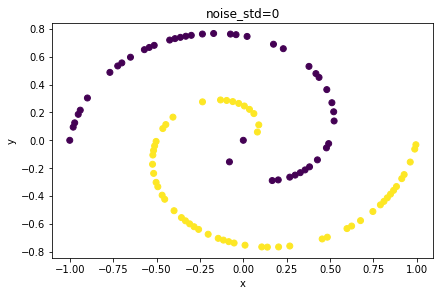

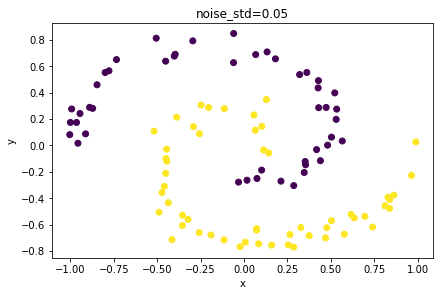

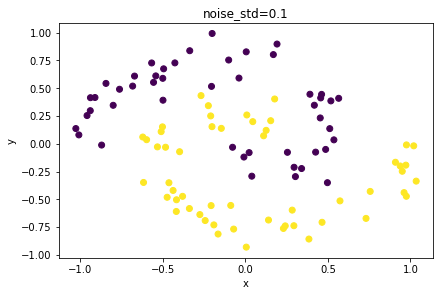

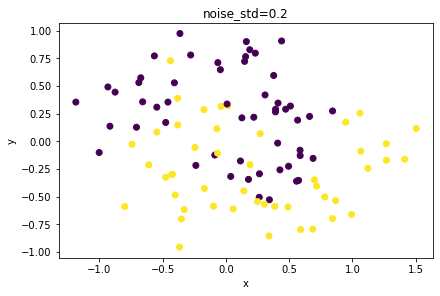

In [ ]:
torch.manual_seed(0)


def make_spirals(
    n_samples: int, noise_std: float = 0.2, rotations: float = 1
) -> tuple[Tensor, Tensor]:
    """Create a binary classification dataset of two interweaving spirals with different
    class labels.

    Args:
        n_samples (int): Number of samples to generate.
        noise_std (float, optional): Amount of Gaussian noise to add to (x, y).
            Defaults to 0.1.
        rotations (float, optional): The more rotations, the more interweaved the
            spirals and the harder they will be for the model to separate based on (x,y)
            position. Defaults to 1.

    Returns:
        tuple[Tensor, Tensor]: (n_samples, 2) tensor of (x, y) coordinates and
            (n_samples,) tensor of class labels.
    """
    rs = torch.linspace(0, 1, n_samples, device=device) ** 0.5
    thetas = rs * rotations * 2 * torch.pi
    signs = torch.randint(0, 2, [n_samples], device=device) * 2 - 1
    labels = (signs > 0).to(torch.long).to(device)

    x_noise = torch.randn(n_samples, device=device) * noise_std
    xs = rs * signs * torch.cos(thetas) + x_noise

    y_noise = torch.randn(n_samples, device=device) * noise_std
    ys = rs * signs * torch.sin(thetas) + y_noise

    points = torch.stack([xs, ys], dim=1)

    return points, labels


# visualize different noise levels and then train model on the noisiest one
labels: list[Tensor] = []
points: list[Tensor] = []
for noise_std in (0, 0.05, 0.1, 0.2):
    points, labels = make_spirals(100, noise_std=noise_std)

    plt.scatter(*points.T, c=labels)
    plt.gca().set(xlabel="x", ylabel="y", title=f"{noise_std=}")
    plt.show()

## Step 2: Define two-layer MLP and loss function


In [ ]:
class MLPClassifier(torch.nn.Module):
    """Just your average fully-connected neural network."""

    def __init__(self, hidden_dim: int = 32, n_classes: int = 2) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_classes = n_classes

        self.fc1 = torch.nn.Linear(2, self.hidden_dim)
        self.fc2 = torch.nn.Linear(self.hidden_dim, self.n_classes)

    def forward(self, x: Tensor) -> Tensor:
        """Define model call."""
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, -1)


loss_fn = torch.nn.NLLLoss()

## Step 3: Make the model functional and define a training function


In [ ]:
func_model, weights = functorch.make_functional(MLPClassifier().to(device))


def train_step_fn(
    weights: Tensor, batch: Tensor, targets: Tensor, lr: float = 0.2
) -> tuple[Tensor, Tensor, Tensor]:
    """This function performs a single training step.

    Args:
        weights (Tensor): Model weights.
        batch (Tensor): Mini-batch of training samples.
        targets (Tensor): Ground truth labels for the mini-batch.
        lr (float, optional): Learning rate. Defaults to 0.2.

    Returns:
        tuple[Tensor, Tensor, Tensor]: Loss, accuracy, and updated weights.
    """

    def compute_loss(weights: Tensor, batch: Tensor, targets: Tensor) -> Tensor:
        output = func_model(weights, batch)
        return loss_fn(output, targets)

    def accuracy(weights: Tensor, batch: Tensor, targets: Tensor) -> Tensor:
        output = func_model(weights, batch)
        return (output.argmax(dim=1) == targets).float().mean()

    grad_weights, loss = functorch.grad_and_value(compute_loss)(weights, batch, targets)

    # NB: PyTorch is missing a "functional optimizer API" (possibly coming soon)
    # so we are going to re-implement SGD here.
    new_weights = []
    with torch.no_grad():
        for grad_weight, weight in zip(grad_weights, weights):
            new_weights.append(weight - grad_weight * lr)

    acc = accuracy(new_weights, batch, targets)

    return loss, acc, new_weights

## Step 4: Verify this actually trains with single model first

If so, loss should decrease with step count while accuracy goes up.


Text(0, 0.5, 'accuracy')

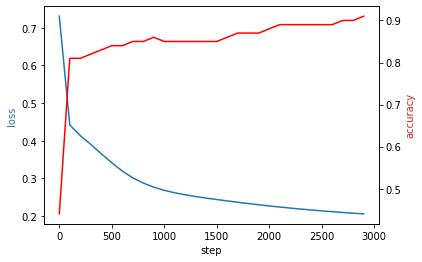

In [ ]:
# If so, the loss should decrease with step count.


metrics = {}
for step in range(n_train_steps):
    loss, acc, weights = train_step_fn(weights, points, labels)
    if step % 100 == 0:
        metrics[step] = {"loss": loss.item(), "acc": acc.item()}


ax = plt.gca()
ax.plot(list(metrics), [v["loss"] for v in metrics.values()])
ax.set(xlabel="step")
ax.set_ylabel("loss", color="tab:blue")
ax2 = ax.twinx()
ax2.plot(list(metrics), [v["acc"] for v in metrics.values()], color="red")
ax2.set_ylabel("accuracy", color="tab:red")

In [ ]:
def initialize_ensemble(n_models: int) -> tuple[Tensor, ...]:
    """Given a number of models, this function returns all their initial weights."""
    models = [MLPClassifier().to(device) for _ in range(n_models)]
    _, params, _ = functorch.combine_state_for_ensemble(models)
    return params

## Step 6: Thanks to functorch, we can train an ensemble of multiple models in parallel

Metrics like losses and accuracies are all tuples here, one scalar per model.


In [ ]:
# at the same time! Note that metrics like losses and accuracies are all tuples here,
# one scalar per model.


parallel_train_step_fn = functorch.vmap(train_step_fn, in_dims=(0, None, None))
batched_weights = initialize_ensemble(n_models=5)
for step in tqdm(range(n_train_steps), desc="training MLP ensemble"):
    losses, accuracies, batched_weights = parallel_train_step_fn(
        batched_weights, points, labels
    )

    loss_dict = {f"model {idx}": loss for idx, loss in enumerate(losses, 1)}
    writer.add_scalars("training/loss", loss_dict, step)

    accuracy_dict = {f"model {idx}": acc for idx, acc in enumerate(accuracies, 1)}
    writer.add_scalars("training/accuracy", accuracy_dict, step)

training MLP ensemble: 100%|██████████| 3000/3000 [00:04<00:00, 715.93it/s]


## Step 8: Get mean and standard deviation for loss and accuracy of ensemble

This is where `tensorboard-reducer` comes in!


In [ ]:
for metric in ("accuracy", "loss"):
    glob_pattern = f"{writer.log_dir}/training_{metric}_model *"
    input_event_dirs = sorted(glob(glob_pattern))

    events_out_dir = f"{writer.log_dir}/training_{metric}"
    reduce_ops = ("mean", "std")

    events_dict = tbr.load_tb_events(input_event_dirs, verbose=True)

    reduced_events = tbr.reduce_events(events_dict, reduce_ops, verbose=True)

    out_dirs = tbr.write_tb_events(
        reduced_events, events_out_dir, overwrite=True, verbose=True
    )

Reading tags: 100%|██████████| 5/5 [00:00<00:00, 791.41it/s]
Writing mean+std reduction to disk...
Writing mean-std reduction to disk...


Loaded 5 TensorBoard runs with 1 scalars and 3000 steps each
Reduced 1 scalars with 2 operations: (mean, std)


Writing mean reduction to disk: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Created new TensorBoard event files in
- functorch-ensemble-runs/training_accuracy-mean+std
- functorch-ensemble-runs/training_accuracy-mean-std
- functorch-ensemble-runs/training_accuracy-mean


Reading tags: 100%|██████████| 5/5 [00:00<00:00, 723.98it/s]
Writing mean+std reduction to disk...
Writing mean-std reduction to disk...


Loaded 5 TensorBoard runs with 1 scalars and 3000 steps each
Reduced 1 scalars with 2 operations: (mean, std)


Writing mean reduction to disk: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

Created new TensorBoard event files in
- functorch-ensemble-runs/training_loss-mean+std
- functorch-ensemble-runs/training_loss-mean-std
- functorch-ensemble-runs/training_loss-mean


This is what the newly created TensorBoard event files look like:

![functorch ensemble mean+/-std](../assets/2022-08-05-functorch-ensemble-landscape.png)


Alternatively, the same result can achieved using the CLI.

> Note that we append the `--overwrite` flag to avoid throwing an error when `tb-reducer` finds existing reduction output from the cell above (if you already ran that).


In [ ]:
for metric in ("accuracy", "loss"):  # noqa: B007
    !tb-reducer {writer.log_dir}/training_{metric}* \
        --outpath {writer.log_dir}/training_{metric} \
        --reduce-ops mean,std,min,max \
        --overwrite

Loaded 10 TensorBoard runs with 1 scalars and 3000 steps each
training/accuracy
Wrote 'mean' reduction to 'functorch-ensemble-runs/training_accuracy-mean'
Wrote 'std' reduction to 'functorch-ensemble-runs/training_accuracy-std'
Wrote 'min' reduction to 'functorch-ensemble-runs/training_accuracy-min'
Wrote 'max' reduction to 'functorch-ensemble-runs/training_accuracy-max'
Loaded 10 TensorBoard runs with 1 scalars and 3000 steps each
training/loss
Wrote 'mean' reduction to 'functorch-ensemble-runs/training_loss-mean'
Wrote 'std' reduction to 'functorch-ensemble-runs/training_loss-std'
Wrote 'min' reduction to 'functorch-ensemble-runs/training_loss-min'
Wrote 'max' reduction to 'functorch-ensemble-runs/training_loss-max'
